In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, CuDNN 3007)


In [3]:
# Seed for reproduciblity
np.random.seed(42)

In [4]:
#!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz
# have to do from commandline, otherwise blocked by firewall

In [5]:
train, val, test = pickle.load(gzip.open('data/mnist/mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

In [6]:
def batch_gen(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')

## 3-conv-pool model

In [7]:
# We need to reshape from a 1D feature vector to a 1 channel 2D image.
# Then we apply 3 convolutional filters with 3x3 kernel size.
l_in = lasagne.layers.InputLayer((None, 28*56))

l_shape = lasagne.layers.ReshapeLayer(l_in, (-1, 1, 28, 56))

l_conv = lasagne.layers.Conv2DLayer(l_shape, num_filters=3, filter_size=3)
l_pool = lasagne.layers.Pool2DLayer(l_conv, pool_size=2, stride=2)
l_conv2 = lasagne.layers.Conv2DLayer(l_pool, num_filters=3, filter_size=2)
l_pool2 = lasagne.layers.Pool2DLayer(l_conv2, pool_size=2, stride=2)
l_conv3 = lasagne.layers.Conv2DLayer(l_pool2, num_filters=3, filter_size=(3,2))
l_pool3 = lasagne.layers.Pool2DLayer(l_conv3, pool_size=2, stride=2)

l_out = lasagne.layers.DenseLayer(l_pool3,
                                  num_units=2,
                                  nonlinearity=lasagne.nonlinearities.softmax)


### Dense model

In [8]:
nonlin = lasagne.nonlinearities.rectify
l_in = lasagne.layers.InputLayer((None, 28*56))
# reshape just for convenience of heatmap function later
l_shape = lasagne.layers.ReshapeLayer(l_in, (-1, 1, 28, 56))
l_out = lasagne.layers.DenseLayer(l_shape,
                                  num_units=5,
                                  nonlinearity=nonlin)
l_out = lasagne.layers.DenseLayer(l_out,
                                  num_units=5,
                                  nonlinearity=nonlin)
l_out = lasagne.layers.DenseLayer(l_out,
                                  num_units=2,
                                  nonlinearity=lasagne.nonlinearities.softmax)

In [9]:
from braindecode.veganlasagne.layer_util import print_layers

In [10]:
print_layers(l_out)

 0 InputLayer                                                         (None, 1568)
 1 ReshapeLayer                                                       (None, 1, 28, 56)
 2 DenseLayer                                         rectify         (None, 5)
 3 DenseLayer                                         rectify        
 4 DenseLayer                                         softmax         (None, 2)



In [11]:
X_train_topo = X_train.reshape(X_train.shape[0], 28,28)
X_val_topo = X_val.reshape(X_val.shape[0], 28,28)


In [12]:
from numpy.random import RandomState

rng = RandomState(98787)
random_inds = range(len(X_train))
rng.shuffle(random_inds)

X_train_topo_both = np.concatenate([X_train_topo, X_train_topo[random_inds]], axis=2)
X_train_flat_both = X_train_topo_both.reshape(X_train_topo_both.shape[0],-1)
y_train_both = np.logical_or(y_train < 3, y_train[random_inds] < 3).astype(np.int32)

rng = RandomState(987837)
random_val_inds = range(len(X_val))
rng.shuffle(random_val_inds)
X_val_topo_both = np.concatenate([X_val_topo, X_val_topo[random_val_inds]], axis=2)
X_val_flat_both = X_val_topo_both.reshape(X_val_topo_both.shape[0],-1)
y_val_both = np.logical_or(y_val < 3, y_val[random_val_inds] < 3).astype(np.int32)


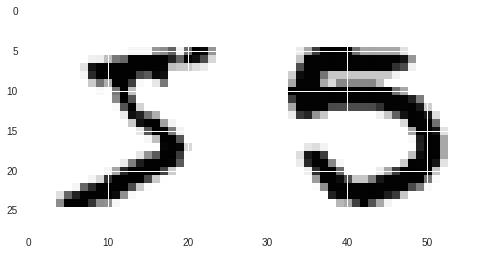

In [13]:
plt.imshow(X_train_topo_both[0], interpolation='nearest')

In [15]:
# Compile and train the network.
# Accuracy is much better than the single layer network, despite the small number of filters.
X_sym = T.matrix()
y_sym = T.ivector()

output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))

acc = T.mean(T.eq(pred, y_sym))

params = lasagne.layers.get_all_params(l_out)

# add bias loss
for bias in params[1::2]:
    loss += T.sum(T.sqr(bias * (bias >0)))
    loss -= T.sum(T.sqr(bias * (bias <0) * (bias > -0.05)))

grad = T.grad(loss, params)
updates = lasagne.updates.adam(grad, params, learning_rate=0.005)

f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)
f_val = theano.function([X_sym, y_sym], [loss, acc])
f_predict = theano.function([X_sym], pred)

BATCH_SIZE = 64
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

train_batches = batch_gen(X_train_flat_both, y_train_both, BATCH_SIZE)
val_batches = batch_gen(X_val_flat_both, y_val_both, BATCH_SIZE)

#### Addition from me :see values before train (robintibor@gmail.com) ####
train_loss = 0
train_acc = 0
for _ in range(N_BATCHES):
    X, y = next(train_batches)
    loss, acc = f_val(X, y)
    train_loss += loss
    train_acc += acc
train_loss /= N_BATCHES
train_acc /= N_BATCHES

val_loss = 0
val_acc = 0
for _ in range(N_VAL_BATCHES):
    X, y = next(val_batches)
    loss, acc = f_val(X, y)
    val_loss += loss
    val_acc += acc
val_loss /= N_VAL_BATCHES
val_acc /= N_VAL_BATCHES
print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
        -1, train_loss, val_loss, val_loss/train_loss))
print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))
### End Addition from me (robintibor@gmail.com) ####

for epoch in range(10):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
            epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch -1, Train (val) loss 0.168 (0.177) ratio 1.055
Train (val) accuracy 0.941 (0.939)
Epoch 0, Train (val) loss 0.171 (0.192) ratio 1.119
Train (val) accuracy 0.942 (0.929)
Epoch 1, Train (val) loss 0.168 (0.182) ratio 1.082
Train (val) accuracy 0.941 (0.937)
Epoch 2, Train (val) loss 0.162 (0.184) ratio 1.131
Train (val) accuracy 0.944 (0.936)
Epoch 3, Train (val) loss 0.164 (0.189) ratio 1.150
Train (val) accuracy 0.943 (0.934)
Epoch 4, Train (val) loss 0.158 (0.181) ratio 1.144
Train (val) accuracy 0.945 (0.933)
Epoch 5, Train (val) loss 0.156 (0.175) ratio 1.121
Train (val) accuracy 0.947 (0.942)
Epoch 6, Train (val) loss 0.153 (0.174) ratio 1.135
Train (val) accuracy 0.948 (0.942)
Epoch 7, Train (val) loss 0.151 (0.175) ratio 1.158
Train (val) accuracy 0.948 (0.939)
Epoch 8, Train (val) loss 0.148 (0.208) ratio 1.408
Train (val) accuracy 0.949 (0.924)
Epoch 9, Train (val) loss 0.148 (0.179) ratio 1.210
Train (val) accuracy 0.949 (0.940)


In [16]:
lasagne.layers.get_all_param_values(lasagne.layers.get_all_layers(l_out))[1::2]

[array([-1.05837369, -0.28118742, -0.05079203, -0.72035843, -0.10019903], dtype=float32),
 array([-0.0606023 , -0.11233313, -2.69224501, -0.16423835, -0.48130903], dtype=float32),
 array([-3.70844579, -0.08581568], dtype=float32)]

In [17]:
import pickle
pickle.dump(l_out, open('data/mnist/two-digit/dense-relu-negative-bias.pkl', 'w'))

In [17]:
# We can look at the output after the convolutional layer 
filtered = lasagne.layers.get_output(l_conv, X_sym)
f_filter = theano.function([X_sym], filtered)

In [18]:
# Filter the first few training examples
im = f_filter(X_train[:10])
print(im.shape)

(10, 3, 26, 26)


In [19]:
# Rearrange dimension so we can plot the result as RGB images
im = np.rollaxis(np.rollaxis(im, 3, 1), 3, 1)

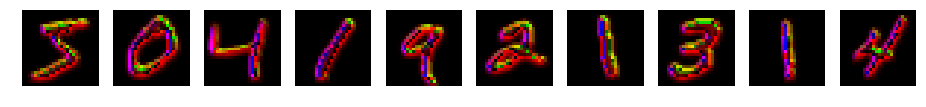

In [20]:
# We can see that each filter seems different features in the images
# ie horizontal / diagonal / vertical segments
plt.figure(figsize=(16,8))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(im[i], interpolation='nearest')
    plt.axis('off')